In [3]:
import torch
import torchvision
import tqdm
import os

from transformers import CLIPVisionModelWithProjection, ViTForImageClassification, AutoModelForCausalLM
from transformers import AutoModel, AutoTokenizer
import numpy as np

from huggingface_hub import try_to_load_from_cache, _CACHED_NO_EXIST
from huggingface_hub import scan_cache_dir

## weight FT 해보기

In [5]:
from sklearn.feature_selection import mutual_info_regression
import numpy as np

import torch
from transformers import CLIPVisionModelWithProjection, ViTForImageClassification, AutoModelForCausalLM
from transformers import AutoModel, AutoTokenizer

ckpt_path = '/home/jgryu/Weight_compression/model_cache/models--meta-llama--Meta-Llama-3-8B/snapshots/8cde5ca8380496c9a6cc7ef3a8b46a0372a1d920'
net = AutoModelForCausalLM.from_pretrained(ckpt_path, local_files_only=True)

# mean = np.load(f'/home/jgryu/Weight_compression/Wparam_dataset_v0/TFRecord/meta-llama--Meta-Llama-3-8B/mlp/d16/mlp_d16_train_mean.npy')
# std = np.load(f'/home/jgryu/Weight_compression/Wparam_dataset_v0/TFRecord/meta-llama--Meta-Llama-3-8B/mlp/d16/mlp_d16_train_std.npy')
# mean = torch.from_numpy(mean)
# std = torch.from_numpy(std)

state_dict = net.state_dict()

for k, v in state_dict.items():
    print(k, v.shape)


Loading checkpoint shards: 100%|██████████| 4/4 [00:06<00:00,  1.51s/it]

model.embed_tokens.weight torch.Size([128256, 4096])
model.layers.0.self_attn.q_proj.weight torch.Size([4096, 4096])
model.layers.0.self_attn.k_proj.weight torch.Size([1024, 4096])
model.layers.0.self_attn.v_proj.weight torch.Size([1024, 4096])
model.layers.0.self_attn.o_proj.weight torch.Size([4096, 4096])
model.layers.0.mlp.gate_proj.weight torch.Size([14336, 4096])
model.layers.0.mlp.up_proj.weight torch.Size([14336, 4096])
model.layers.0.mlp.down_proj.weight torch.Size([4096, 14336])
model.layers.0.input_layernorm.weight torch.Size([4096])
model.layers.0.post_attention_layernorm.weight torch.Size([4096])
model.layers.1.self_attn.q_proj.weight torch.Size([4096, 4096])
model.layers.1.self_attn.k_proj.weight torch.Size([1024, 4096])
model.layers.1.self_attn.v_proj.weight torch.Size([1024, 4096])
model.layers.1.self_attn.o_proj.weight torch.Size([4096, 4096])
model.layers.1.mlp.gate_proj.weight torch.Size([14336, 4096])
model.layers.1.mlp.up_proj.weight torch.Size([14336, 4096])
model.

In [8]:
import numpy as np
from scipy.fft import dct, idct

# # 샘플 데이터
# data = np.array([1.0, 2.0, 3.0, 4.0])

# # DCT 계산 (타입-II가 가장 일반적)
# dct_result = dct(data, type=2, norm='ortho')

# # IDCT 계산 (역변환)
# idct_result = idct(dct_result, type=2, norm='ortho')

# print("Original Data:", data)
# print("DCT Result:", dct_result)
# print("Reconstructed Data (IDCT):", idct_result)


# for k, v in state_dict.items():
#     print(k, v.shape)
#     v =(v - mean) / std
#     data = v.reshape(-1, 64)[45].numpy()
#     dct_result = dct(data, type=2, norm='ortho')
#     idct_result = idct(dct_result, type=2, norm='ortho')
#     print("Original Data:", data)
#     print("DCT Result:", dct_result)
#     print("Reconstructed Data (IDCT):", idct_result)
#     break

plot_data = {}
for k, v in state_dict.items():
    if 'layernorm' in k or 'embed' in k: continue
    # if 'layers.0.' in k or 'layers.10.' in k or 'layers.30.' in k:
    if 'layers.0.' in k:
        print(k, v.shape)
        # v = v.T
        mean = v.mean(dim=0)
        std = v.std(dim=0)
        v =(v - mean) / std
        data = v.T.reshape(-1, 1024).numpy()
        dct_all = []
        for i in data:
            # print(i)
            dct_result = dct(i, type=2, norm='ortho')
            dct_all.append(dct_result)
            
        np.set_printoptions(threshold=np.inf)
        dct_all = np.vstack(dct_all).mean(0)
        plot_data[k] = dct_all

model.layers.0.self_attn.q_proj.weight torch.Size([4096, 4096])
model.layers.0.self_attn.k_proj.weight torch.Size([1024, 4096])
model.layers.0.self_attn.v_proj.weight torch.Size([1024, 4096])
model.layers.0.self_attn.o_proj.weight torch.Size([4096, 4096])
model.layers.0.mlp.gate_proj.weight torch.Size([14336, 4096])
model.layers.0.mlp.up_proj.weight torch.Size([14336, 4096])
model.layers.0.mlp.down_proj.weight torch.Size([4096, 14336])


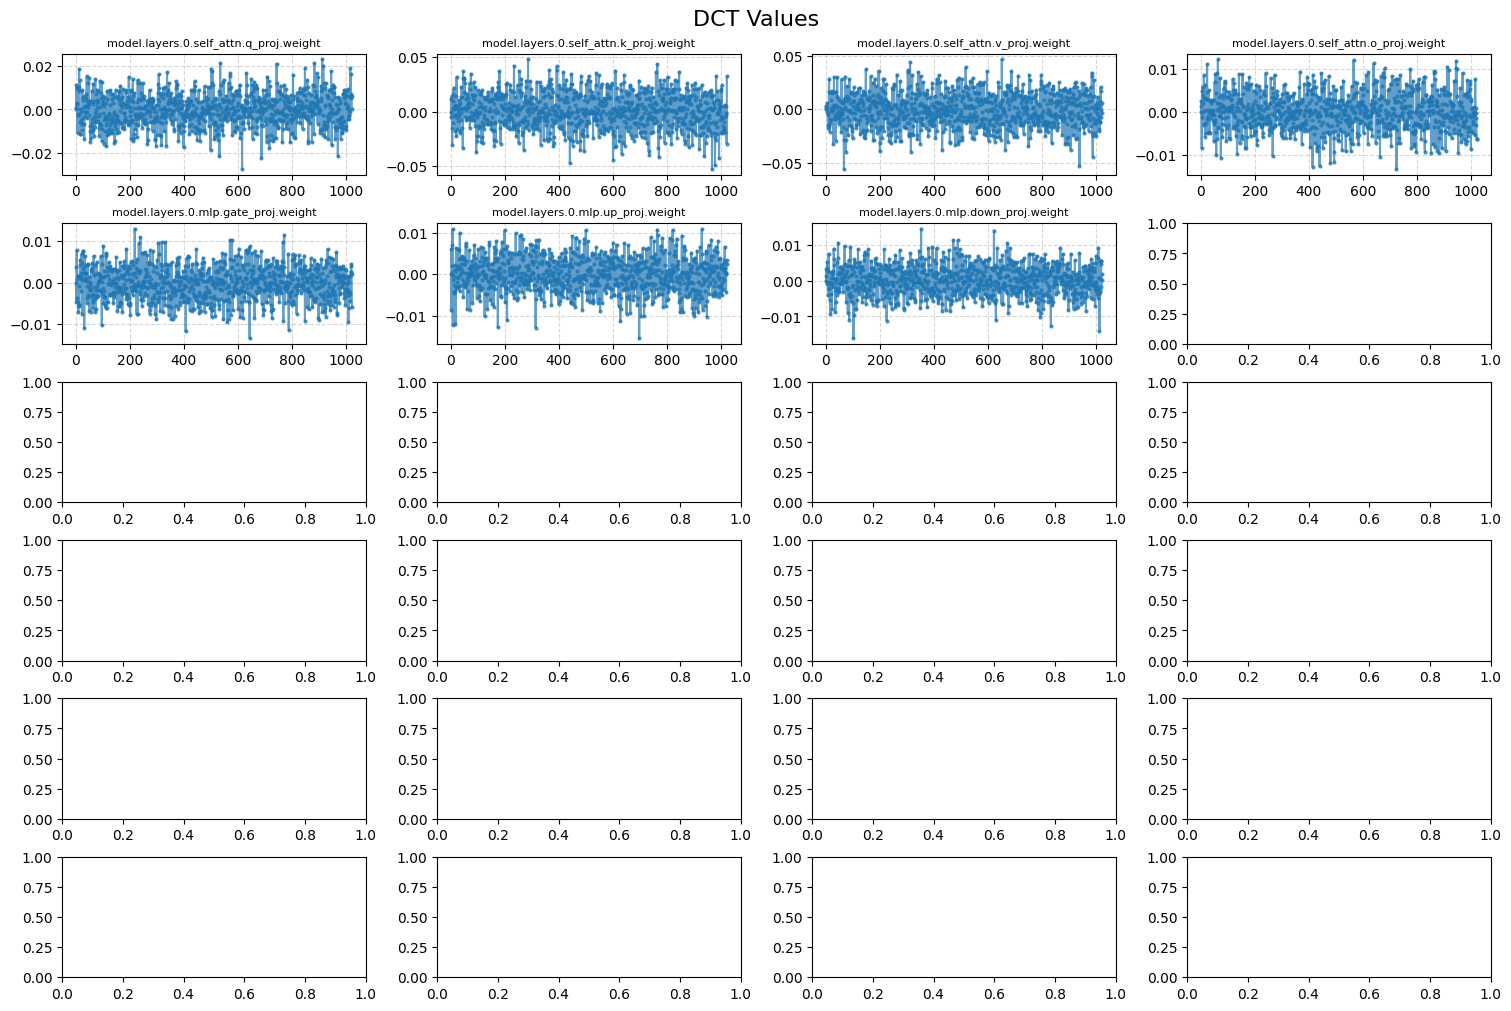

In [9]:
import numpy as np
import matplotlib.pyplot as plt
scaled_dct_all = dct_all * 255

# 그래프 그리기


# plt.figure(figsize=(10, 6))
# plt.plot(plot_data['model.layers.10.self_attn.k_proj.weight'], marker='o', markersize=2, linestyle='-', alpha=0.7)
# plt.title('Model Weight, layer10 k', fontsize=16)
# plt.xlabel('Index', fontsize=12)
# plt.ylabel('DCT Value', fontsize=12)
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.tight_layout()
# plt.show()


fig, axes = plt.subplots(6, 4, figsize=(15, 10), constrained_layout=True)
axes = axes.flatten()

for idx, (key, data) in enumerate(plot_data.items()):
    if 'layernorm' in key or 'embed' in key: continue
    axes[idx].plot(data, marker='o', markersize=2, linestyle='-', alpha=0.7)
    axes[idx].set_title(key, fontsize=8)
    axes[idx].grid(True, linestyle='--', alpha=0.5)

# 전체 그래프 제목 추가
plt.suptitle('DCT Values', fontsize=16)
plt.show()


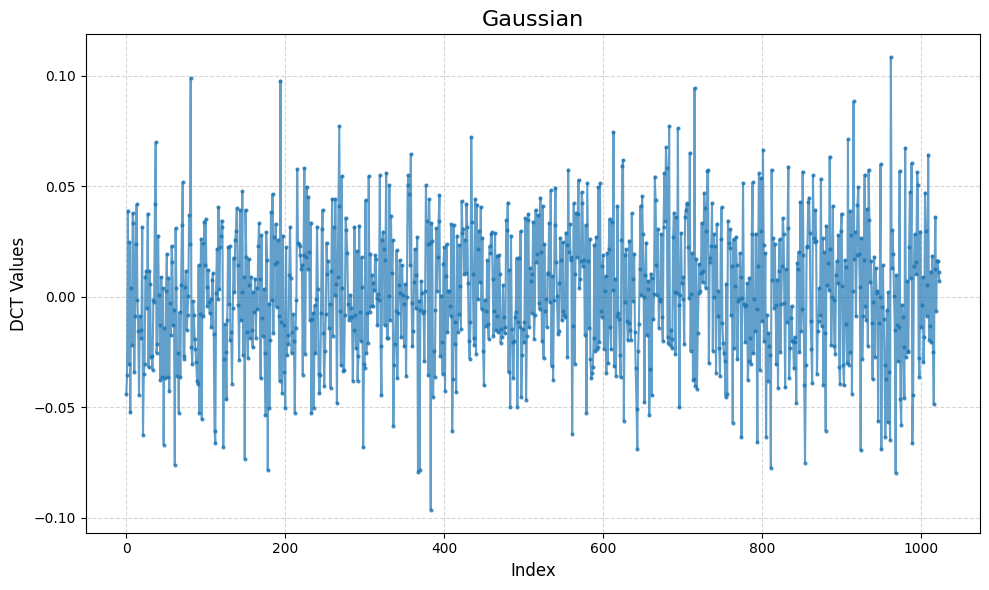

In [42]:
X = np.random.randn(1000, 1024) 
dct_all_gaussian = []
for i in X:
    # print(i)
    dct_result = dct(i, type=2, norm='ortho')
    dct_all_gaussian.append(dct_result)
dct_result = dct(i, type=2, norm='ortho')
dct_all_gaussian.append(dct_result)

np.set_printoptions(threshold=np.inf)
dct_all_gaussian = np.vstack(dct_all_gaussian).mean(0)

plt.figure(figsize=(10, 6))
plt.plot(dct_all_gaussian, marker='o', markersize=2, linestyle='-', alpha=0.7)
plt.title('Gaussian', fontsize=16)
plt.xlabel('Index', fontsize=12)
plt.ylabel('DCT Values', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()